In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot12DimsNS_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DDimsNS"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DDimsNS/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file and "MSEs" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0).dropna()
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [4]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)
print(mses)

           bw          mse
0    0.000282  3136.600098
1    0.000372  3136.564697
2    0.000491  3136.506104
3    0.000649  3136.421387
4    0.000857  3136.322754
5    0.001131  3136.059570
6    0.001493  3135.577881
7    0.001972  3134.875000
8    0.002603  3133.718994
9    0.003437  3131.673584
10   0.004538  3127.903564
11   0.005992  3121.036865
12   0.007912  3108.957275
13   0.010446  3088.333740
14   0.013793  3053.429443
15   0.018211  2992.024658
16   0.024046  2884.584229
17   0.031749  2703.281250
18   0.041919  2396.972412
19   0.055348  1902.425415
20   0.073079  1205.448120
21   0.096490   512.601501
22   0.127401   150.938995
23   0.168214    61.356571
24   0.222102    45.246735
25   0.293252    47.216148
26   0.387196    54.739719
27   0.511235    61.285973
28   0.675010    65.930931
29   0.891251    69.031403
30   1.135011    70.805000
31   1.445440    71.976738
32   1.840772    72.735962
33   2.344229    73.220428
34   2.985383    73.526039
35   3.801894    73.717293
3

Text(0.5, 1.0, 'Minimum MSE is (45.246735, 24)')

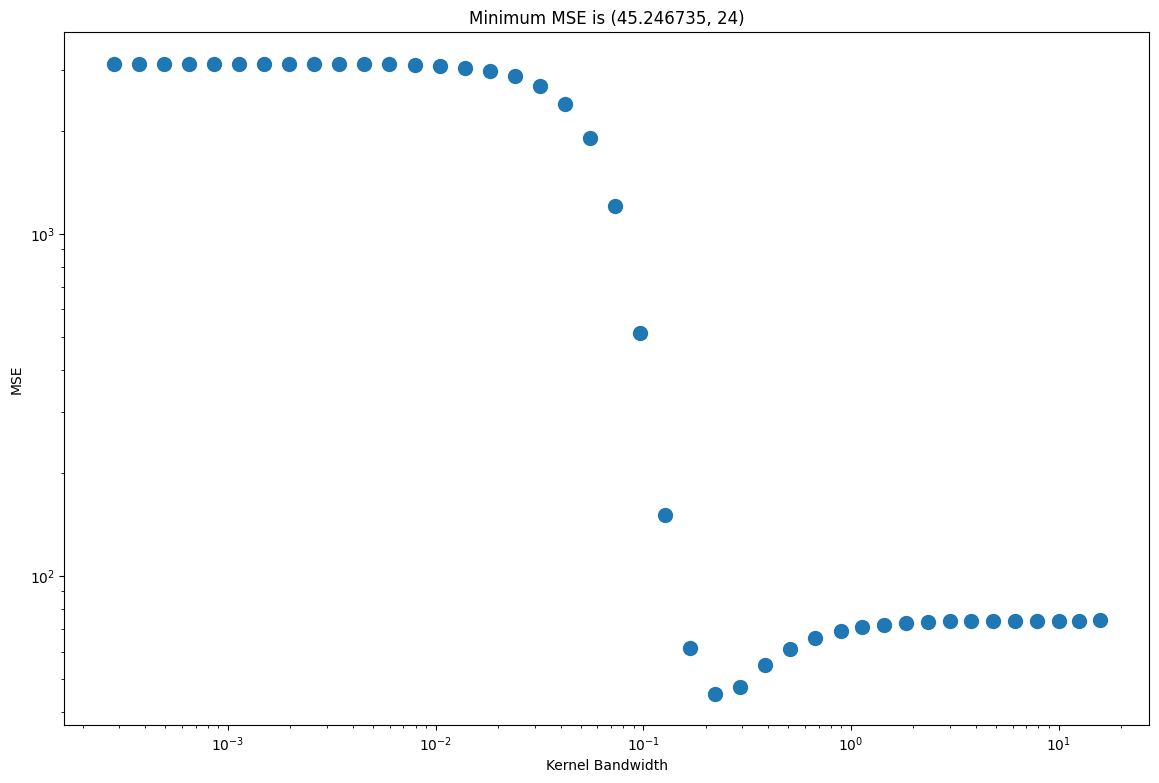

In [5]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

In [6]:
data = np.load(config.data_path, allow_pickle=True)

In [7]:
ts = data[0, :, :]
